<a href="https://colab.research.google.com/github/rushirajsherlocked/Awesome-PyTorch/blob/master/Resnet_50_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn

# Implementing the Conv Blocks

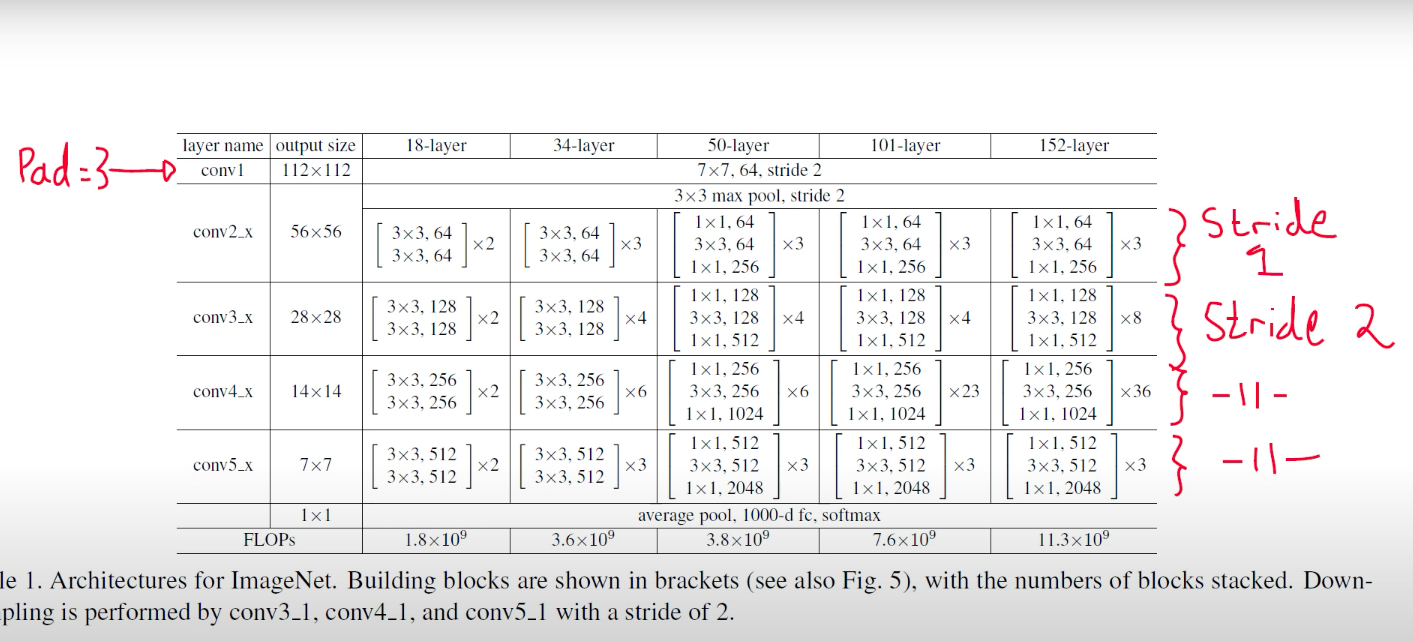

In [3]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [4]:

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


In [6]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to(device)
    print(y.size())


test()

torch.Size([4, 1000])


## Visualising Tensor shapes for better understanding

In [7]:
def print_sizes(self, input, output):
  
    print('\n' + self.__class__.__name__)
    
    if self.__class__.__name__.startswith('Conv'):
      print(f'\tkernel: {self.kernel_size}\n\tpadding: {self.padding}\n\tstride: {self.stride}')

    if self.__class__.__name__.startswith('MaxPool') or self.__class__.__name__.startswith('AvgPool'):
      print(f'\tkernel: {self.kernel_size}\n\tpadding: {self.padding}\n\tstride: {self.stride}')
    
    if not (self.__class__.__name__.startswith('ReLU') or self.__class__.__name__.startswith('BatchNorm')):
      print('\tinput size:', input[0].size())
      print('\toutput size:', output.data.size())

In [8]:
def layer_hook(self, input, output):
    print("\n\t\t------ Layer boundary ------\n")

In [9]:
model = ResNet50()


In [10]:
for el in [model.conv1, model.bn1, model.relu, model.maxpool, model.avgpool, model.fc]:
  print(el.register_forward_hook(print_sizes))
  
for layer in [model.layer1, model.layer2, model.layer3, model.layer4]:
  layer.register_forward_hook(layer_hook)
  for i, el in enumerate(layer.children()):
    for el1 in el.children():
      if type(el1) == torch.nn.modules.container.Sequential:
        for el2 in el1.children():
          el2.register_forward_hook(print_sizes)
      else:
        el1.register_forward_hook(print_sizes)

In [12]:
img = torch.randn(1,3,224,224, dtype=torch.float)
output_tensor = model(img)


Conv2d
	kernel: (7, 7)
	padding: (3, 3)
	stride: (2, 2)
	input size: torch.Size([1, 3, 224, 224])
	output size: torch.Size([1, 64, 112, 112])

BatchNorm2d

ReLU

MaxPool2d
	kernel: 3
	padding: 1
	stride: 2
	input size: torch.Size([1, 64, 112, 112])
	output size: torch.Size([1, 64, 56, 56])

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([1, 64, 56, 56])
	output size: torch.Size([1, 64, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (3, 3)
	padding: (1, 1)
	stride: (1, 1)
	input size: torch.Size([1, 64, 56, 56])
	output size: torch.Size([1, 64, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([1, 64, 56, 56])
	output size: torch.Size([1, 256, 56, 56])

BatchNorm2d

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([1, 64, 56, 56])
	output size: torch.Size([1, 256, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.

[Full PDF with input shape and output shape explanation](https://dhruvs.space/files/resnets/resnet-34-pytorch-debug.pdf)

credits for the wonderful explanation: Dhruv S, [Simple and clear Resnet Explanation](https://dhruvs.space/posts/understanding-resnets/#what-problems-did-the-residual-learning-framework-try-to-solve)

In [13]:
from torchsummary import summary

summary(model, (3, 224, 224))  # Channels = 3

# IMP to check and understand how tensor shape changes after each layer and the no. of parameters as well


Conv2d
	kernel: (7, 7)
	padding: (3, 3)
	stride: (2, 2)
	input size: torch.Size([2, 3, 224, 224])
	output size: torch.Size([2, 64, 112, 112])

BatchNorm2d

ReLU

MaxPool2d
	kernel: 3
	padding: 1
	stride: 2
	input size: torch.Size([2, 64, 112, 112])
	output size: torch.Size([2, 64, 56, 56])

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([2, 64, 56, 56])
	output size: torch.Size([2, 64, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (3, 3)
	padding: (1, 1)
	stride: (1, 1)
	input size: torch.Size([2, 64, 56, 56])
	output size: torch.Size([2, 64, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([2, 64, 56, 56])
	output size: torch.Size([2, 256, 56, 56])

BatchNorm2d

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([2, 64, 56, 56])
	output size: torch.Size([2, 256, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.

# Carefully look below to understand in detail

In [14]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256,

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')



# Less than VGG
# VGG has 37,702,696 trainable parameters

The model has 25,583,592 trainable parameters


In [ ]:
!pip install graphviz
!pip install torchviz

from graphviz import Digraph
import torch
from torch.autograd import Variable


# make_dot was moved to https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot


Conv2d
	kernel: (7, 7)
	padding: (3, 3)
	stride: (2, 2)
	input size: torch.Size([4, 3, 224, 224])
	output size: torch.Size([4, 64, 112, 112])

BatchNorm2d

ReLU

MaxPool2d
	kernel: 3
	padding: 1
	stride: 2
	input size: torch.Size([4, 64, 112, 112])
	output size: torch.Size([4, 64, 56, 56])

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([4, 64, 56, 56])
	output size: torch.Size([4, 64, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (3, 3)
	padding: (1, 1)
	stride: (1, 1)
	input size: torch.Size([4, 64, 56, 56])
	output size: torch.Size([4, 64, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([4, 64, 56, 56])
	output size: torch.Size([4, 256, 56, 56])

BatchNorm2d

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.Size([4, 64, 56, 56])
	output size: torch.Size([4, 256, 56, 56])

BatchNorm2d

ReLU

Conv2d
	kernel: (1, 1)
	padding: (0, 0)
	stride: (1, 1)
	input size: torch.

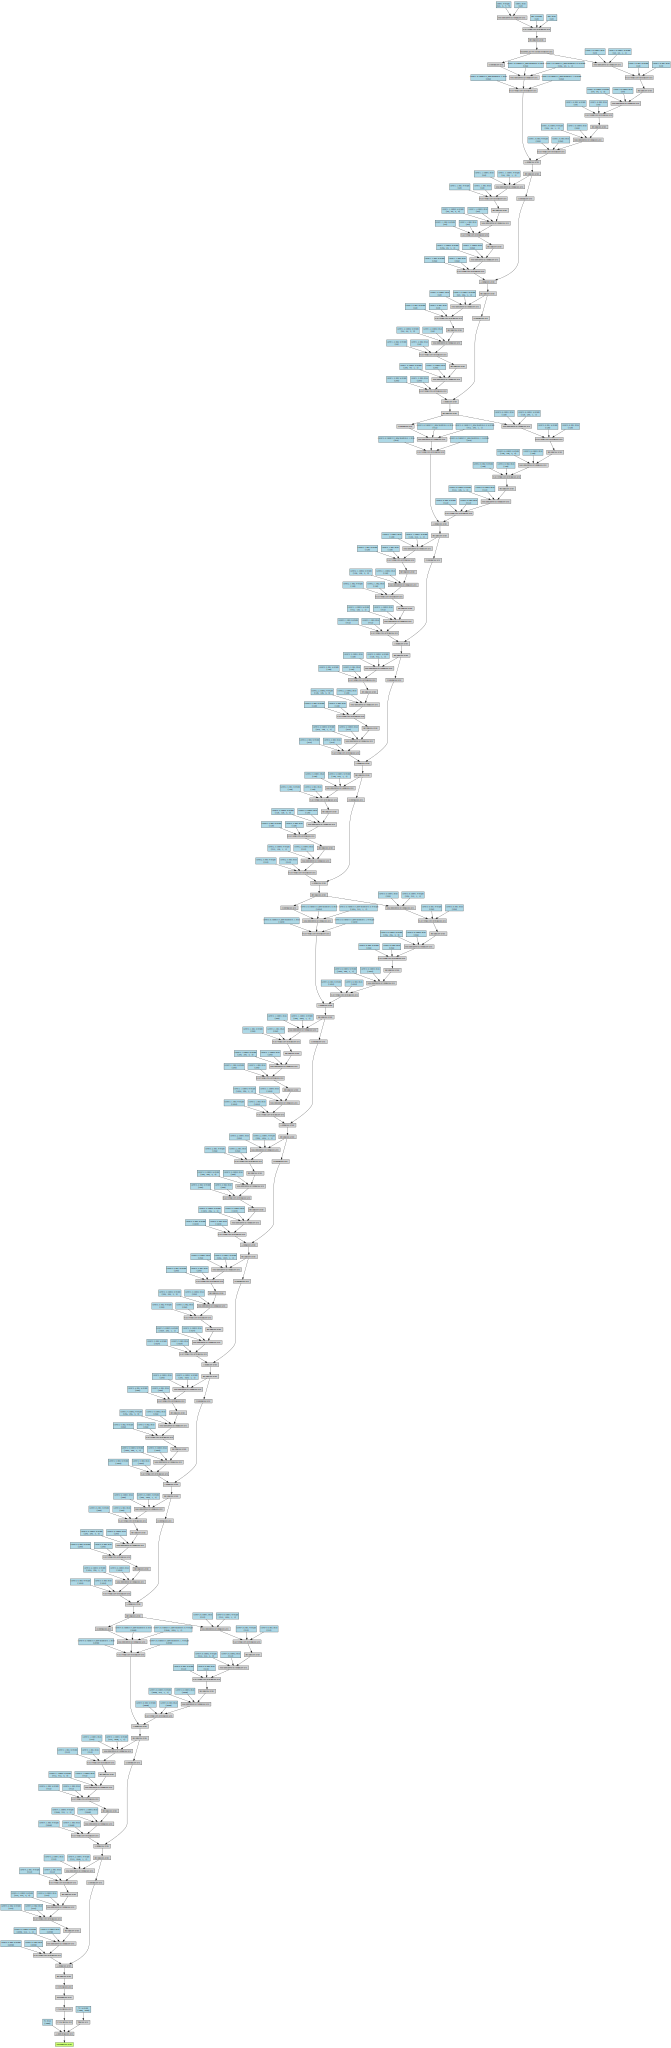

In [22]:
x = torch.randn(4, 3, 224, 224)
y = model(x)
make_dot(y.mean(), params = dict(model.named_parameters()))